/tmp/ipykernel_2424/2597571282.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels, cmap=matplotlib.cm.get_cmap('RdYlBu'))


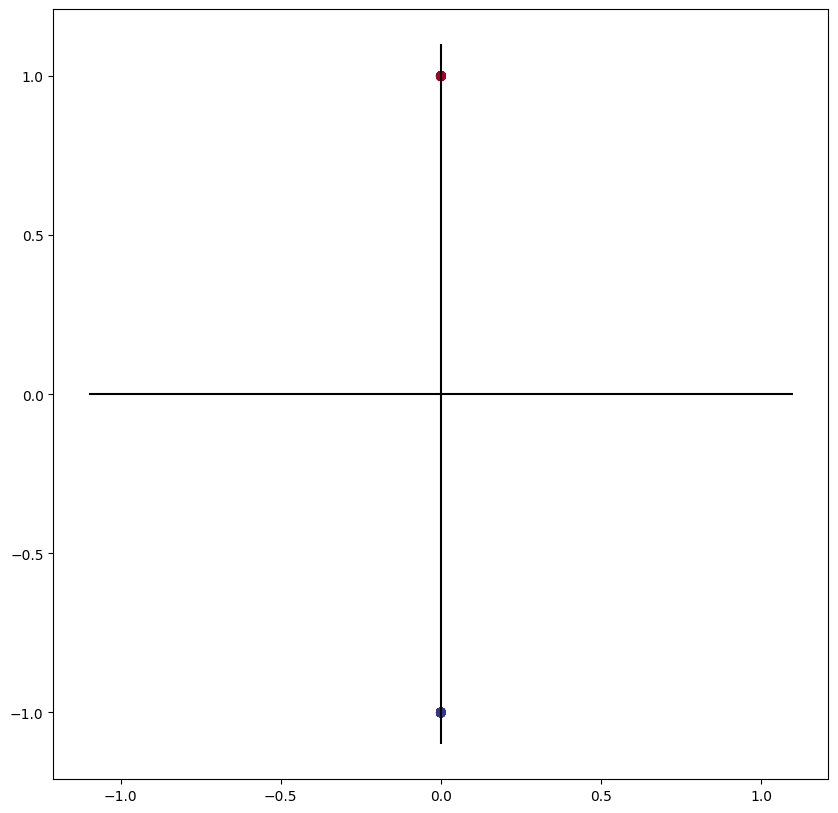

In [1]:
import os, sys, numpy, torch, matplotlib.pyplot, matplotlib.cm, ipycanvas, matplotlib.patches

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from functools import partial
from utils.optimization import initialize
from utils.plots import plot_train_loss, plot_samples_and_neurons, plot_weights_norms, draw_figure_into_canvas, save_figure
from utils.models import EpsilonNetFullyConnectedNeuralNetwork
from settings.sphere_2d_epsilon_net import get_dataloader, sphere_2d_epsilon_net
from experiment import model_summary, plot_neurons_inner_product_to_weights_products, execute_experiment

experiment = {
    'dataset': 'sphere_2d_epsilon_net',
    'epsilon': 1.5,
    'net_epsilon': .4e-5,
    'seed': 2,
    'input_dimension': 2, 
    'sample_size': 100,  
    'batch_size': 100, 
    'within_cluster_variance': 0,
    'epochs': 1000,
    'learning_rate': .1,
    'bias': False,
    'initialization_scale': 1e-5,
    'name_parameters': ['seed'],
    'balance_classes': True
}
rotation_matrix = numpy.identity(experiment['input_dimension'])
device, generator = initialize(experiment['seed'])
train_data = get_dataloader(**experiment, rotation_matrix=rotation_matrix, generator=generator)
test_data = get_dataloader(**experiment, rotation_matrix=rotation_matrix, generator=generator)

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs = []; labels = []
for batch_inputs, batch_labels in train_data: inputs.append(batch_inputs); labels.append(batch_labels)
inputs, labels = torch.concatenate(inputs), torch.concatenate(labels)
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.hlines(0, -inputs_.max() * 1.1, inputs_.max() * 1.1, color='k')
ax.vlines(0, -inputs_.max() * 1.1, inputs_.max() * 1.1, color='k')
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels, cmap=matplotlib.cm.get_cmap('RdYlBu'))
#nodes = sphere_2d_epsilon_net(**experiment)
#ax.add_patch(matplotlib.patches.Circle([0, 0], 1, color='k', alpha=.1, fill=False))
#for node in nodes:
#    ax.add_patch(matplotlib.patches.Circle(node, experiment['epsilon'], color='k', alpha=.05))

In [2]:
matplotlib.pyplot.ioff()
figure, (input_domain_ax, loss_ax) = matplotlib.pyplot.subplots(1, 2, figsize=(16,8))

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1000, 500
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)

plot_samples_and_neurons = partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
plot_train_loss = partial(plot_train_loss, ax=loss_ax)
draw_figure_into_canvas = partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure = partial(save_figure, figure=figure, parameters=experiment, **experiment)

canvas

Canvas(width=1000)

In [3]:
class ExponentialLoss(object):

    def __call__(self, logits, labels): 
        return  (( -( (2.0 * labels.float() - 1.0) * logits ) ).exp()).mean()

experiment, model, decive, generator = execute_experiment(
    **experiment,
    train_data=train_data, 
    test_data=test_data, 
    model_class=EpsilonNetFullyConnectedNeuralNetwork,
    saving_epochs_interval=experiment['epochs'],
    callbacks_epochs=list(range(0, experiment['epochs'], 100)),
    callbacks=[plot_samples_and_neurons, plot_train_loss, draw_figure_into_canvas],
    overwrite=True,
    repeat_nodes=False,
    train_loss_class=ExponentialLoss
)

In [4]:
unregularized_model = model
unregularized_experiment = experiment

In [9]:
import pandas
from utils.plots import plot_series_and_reference_on_ax

blue = matplotlib.colors.to_rgba('blue', alpha=None)

unregularized_model_metrics_df = pandas.DataFrame(unregularized_experiment['model_metrics'])
unregularized_model_metrics_df['iterations'] = (
    unregularized_model_metrics_df['epoch'] * experiment['sample_size']
      / experiment['batch_size']
)

def plot_weights_norms(ax, model, model_metrics, batch_size, sample_size, epoch=None, discard_dead_units=True, *args, **kwargs):
    ax.clear()
    ax.set_title(f'Parameters norms (Epoch = {epoch})')
    ax.set_xlabel('iteration')
    ax.set_ylabel('L2 norm')
    if discard_dead_units:
        positive_neurons = [neuron_index for neuron_index in positive_neurons if neuron_index not in model.dead_units[0]]
        
    negative_neurons = numpy.argwhere(model.output_layer.weight.squeeze(dim=0).detach().cpu().numpy() < 0).reshape(-1).tolist()
    if discard_dead_units:
        negative_neurons = [neuron_index for neuron_index in negative_neurons if neuron_index not in model.dead_units[0]]

    model_metrics_df = pandas.DataFrame(model_metrics)
    model_metrics_df['iterations'] = model_metrics_df['epoch'] * sample_size / batch_size
    
    layer_df = unregularized_model_metrics_df[unregularized_model_metrics_df['layer']==0]
    plot_series_and_reference_on_ax(ax, layer_df['iterations'].tolist(), 
                                    layer_df['neurons_weights_norm'].apply(lambda units_norms: numpy.average(numpy.array(units_norms))).tolist(), 
                                    label=f'$\|w\|$', linestyle='-')

    for layer, layer_df in model_metrics_df.groupby('layer'):
        layer_df = layer_df.dropna(subset=['neurons_weights_norm'])
        plot_series_and_reference_on_ax(ax, layer_df['iterations'].tolist(), 
                                        layer_df['neurons_weights_norm'].apply(lambda units_norms: numpy.average(numpy.array(units_norms))).tolist(), 
                                        label=f'$\|w\|$', linestyle='-')

    ax.legend()
    ax.set_yscale('log')

def plot_alignment(ax, model, model_metrics, batch_size, sample_size, epoch=None, discard_dead_units=True, *args, **kwargs):
    ax.clear()
    ax.set_title(f'Parameters norms (Epoch = {epoch})')
    ax.set_xlabel('iteration')
    ax.set_ylabel('L2 norm')
    if discard_dead_units:
        positive_neurons = [neuron_index for neuron_index in positive_neurons if neuron_index not in model.dead_units[0]]
        
    negative_neurons = numpy.argwhere(model.output_layer.weight.squeeze(dim=0).detach().cpu().numpy() < 0).reshape(-1).tolist()
    if discard_dead_units:
        negative_neurons = [neuron_index for neuron_index in negative_neurons if neuron_index not in model.dead_units[0]]

    model_metrics_df = pandas.DataFrame(model_metrics)
    model_metrics_df['iterations'] = model_metrics_df['epoch'] * sample_size / batch_size
    
    layer_df = model_metrics_df[model_metrics_df['layer']==0]
    plot_series_and_reference_on_ax(ax, layer_df['iterations'].tolist(), 
                                    layer_df['alignment_with_unregularized'].apply(lambda units_norms: numpy.average(numpy.array(units_norms))).tolist(), 
                                    linestyle='-')

    ax.legend()
    ax.set_yscale('log')

In [11]:
matplotlib.pyplot.ioff()
figure, ((input_domain_ax, loss_ax), (parameters_norms_ax, alignment_ax)) = matplotlib.pyplot.subplots(2, 2, figsize=(10, 10))

canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1000, 1000
canvas.font = '30px arial'
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)

plot_samples_and_neurons = partial(plot_samples_and_neurons, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
plot_train_loss = partial(plot_train_loss, ax=loss_ax)
plot_weights_norms = partial(plot_weights_norms, ax=parameters_norms_ax)
plot_alignment = partial(plot_alignment, ax=alignment_ax)
draw_figure_into_canvas = partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure = partial(save_figure, figure=figure, parameters=experiment, **experiment)


canvas

Canvas(height=1000, width=1000)

In [ ]:
def model_summary(model, model_metrics, epoch, *args, **kwargs):
    alignments = (model.layers[0].weight.T * unregularized_model.layers[0].weight / 
                  (model.layers[0].weight.norm(dim=1) * unregularized_model.layers[0].weight.norm(dim=1)))

    model_metrics.append({'epoch': epoch, 'layer': 0,
                          'neurons_weights_norm': model.layers[0].weight.norm(dim=1).detach().cpu().tolist(),
                          'alignment_with_unregularized': alignments.detach().numpy.cpu().tolist()})


execute_experiment(
    **experiment,
    train_data=train_data, 
    test_data=test_data, 
    model_class=EpsilonNetFullyConnectedNeuralNetwork,
    saving_epochs_interval=experiment['epochs'],
    callbacks_epochs=list(range(0, experiment['epochs'], 1000)),
    callbacks=[model_summary, plot_samples_and_neurons, plot_train_loss, 
               plot_weights_norms, plot_alignment, 
               draw_figure_into_canvas, save_figure],
    overwrite=True,
    train_loss_class=ExponentialLoss
)